# The role of topology in decentralized learning

In [3]:
import numpy as np
import numpy.random as rd
import torch
import scipy.optimize as optim
import matplotlib.pyplot as plt

In [4]:
import math
from functools import lru_cache

import networkx



class Topology:
    num_workers: int

    def __init__(self, num_workers):
        self.num_workers = num_workers

    def neighbors(self, worker: int) -> list[int]:
        raise NotImplementedError()

    def degree(self, worker: int) -> int:
        return len(self.neighbors(worker))

    @property
    def workers(self) -> list[int]:
        return list(range(self.num_workers))

    @property
    def max_degree(self) -> int:
        return max(self.degree(w) for w in self.workers)

    def gossip_matrix(self, weight=None) -> torch.Tensor:
        m = torch.zeros([self.num_workers, self.num_workers])
        for worker in self.workers:
            for neighbor in self.neighbors(worker):
                max_degree = max(self.degree(worker), self.degree(neighbor))
                m[worker, neighbor] = 1 / (max_degree + 1) if weight is None else weight
            # self weight
            m[worker, worker] = 1 - m[worker, :].sum()

        return m

    def to_networkx(self) -> networkx.Graph:
        g = networkx.Graph()
        g.add_nodes_from(range(self.num_workers))
        for worker in range(self.num_workers):
            g.add_edges_from(
                [(worker, neighbor) for neighbor in self.neighbors(worker)]
            )
        return g

    @property
    def max_delay(self):
        g = self.to_networkx()
        distances = dict(networkx.all_pairs_shortest_path_length(g))
        return max(distances[i][j] for i in g.nodes for j in g.nodes)


class AveragingScheme:
    # Some defaults
    period = 1
    n = 1

    def init(self):
        return None

    @property
    def state_size(self):
        return self.n

    def w(self, t=0, params=None):
        return torch.eye(1)

    def show_weights(self, params=None, **kwargs):
        fig, axes = plt.subplots(ncols=self.period)
        if self.period == 1:
            axes = [axes]
        for t in range(self.period):
            axes[t].set_title(f"t={t}")
            axes[t].matshow(self.w(params=params, t=t), **kwargs)

        for ax in axes:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

        return fig


class FullyConnectedTopology(Topology):
    def neighbors(self, worker):
        i = worker
        n = self.num_workers
        return [j for j in range(n) if j != i]


class TwoCliquesTopology(Topology):
    def neighbors(self, worker):
        i = worker
        n = self.num_workers
        if i < n // 2:
            neighbors = [j for j in range(0, n // 2) if j != i]
        else:
            neighbors = [j for j in range(n // 2, n) if j != i]

        if i == 0:
            neighbors.append(n // 2)
        elif i == n // 2:
            neighbors.append(0)

        return neighbors


class DisconnectedTopology(Topology):
    def neighbors(self, worker):
        return []


class MixTopology(FullyConnectedTopology):
    r"""
    Symmetric doubly-stochastic gossip matrix with all \lambda_{2...} equal.
    """

    def __init__(self, num_workers, spectral_gap):
        super().__init__(num_workers)
        self.spectral_gap = spectral_gap

        ii = torch.eye(num_workers)
        ee = torch.ones_like(ii) / num_workers
        self.W = spectral_gap * ee + (1 - spectral_gap) * ii

    def gossip_matrix(self):
        return self.W


class StarTopology(Topology):
    def neighbors(self, worker):
        i = worker
        if i == 0:
            n = self.num_workers
            return [j for j in range(n) if j != i]
        else:
            return [0]


class ChainTopology(Topology):
    def neighbors(self, worker):
        if worker < 1:
            return [1]
        elif worker >= self.num_workers - 1:
            return [worker - 1]
        else:
            return [worker - 1, worker + 1]


class RingTopology(Topology):
    def neighbors(self, worker):
        i = worker
        n = self.num_workers
        if n == 1:
            return []
        elif n == 2:
            return [(i + 1) % n]
        else:
            return [(i - 1) % n, (i + 1) % n]


class UnidirectionalRingTopology(Topology):
    def neighbors(self, worker):
        i = worker
        n = self.num_workers
        return [(i + 1) % n]


class HyperCubeTopology(Topology):
    def neighbors(self, worker):
        i = worker
        n = self.num_workers

        d = int(math.log2(n))
        assert 2**d == n

        return [i ^ (2**j) for j in range(0, d)]


class TorusTopology(Topology):
    def __init__(self, n, m):
        self.num_workers = n * m
        self.n = n
        self.m = m

    def neighbors(self, worker):
        # i = col + row * m
        i = worker
        col = i % self.m
        row = i // self.m

        idx = lambda row, col: (col + row * self.m) % self.num_workers

        return [
            idx(row - 1, col),
            idx(row + 1, col),
            idx(row, col - 1),
            idx(row, col + 1),
        ]


class TreeTopology(Topology):
    """A tree that divides nodes such that nodes have the same degree if they are not (close to) leaves"""

    num_workers: int
    max_degree: int

    def __init__(self, num_workers, max_degree):
        super().__init__(num_workers=num_workers)
        self._max_degree = max_degree

    def max_workers_up_to_depth(self, layer_number: int) -> int:
        d = self._max_degree
        n = layer_number
        return int(1 + d * ((d - 1) ** n - 1) / (d - 2))

    def depth_of_worker(self, worker_number: int) -> int:
        # TODO: optimize / give direct formula
        depth = 0
        while True:
            if self.max_workers_up_to_depth(depth) > worker_number:
                return depth
            depth += 1

    def parent(self, worker_number: int) -> int:
        depth = self.depth_of_worker(worker_number)
        if depth == 0:
            return None
        index_within_layer = worker_number - self.max_workers_up_to_depth(depth - 1)
        if depth == 1:
            parent_within_layer = index_within_layer // (self._max_degree)
        else:
            parent_within_layer = index_within_layer // (self._max_degree - 1)
        return parent_within_layer + self.max_workers_up_to_depth(depth - 2)

    def children(self, worker_number: int) -> list[int]:
        if worker_number == 0:
            children = [1 + x for x in range(self._max_degree)]
        else:
            depth = self.depth_of_worker(worker_number)
            start_idx_my_depth = self.max_workers_up_to_depth(depth - 1)
            start_idx_next_depth = self.max_workers_up_to_depth(depth)
            i = worker_number - start_idx_my_depth
            d = self._max_degree
            children = [start_idx_next_depth + (d - 1) * i + x for x in range(d - 1)]
        return [c for c in children if c < self.num_workers]

    def neighbors(self, worker: int) -> list[int]:
        if worker == 0:
            return self.children(worker)
        else:
            return [self.parent(worker)] + self.children(worker)


class NetworkxTopology(Topology):
    def __init__(self, nx_graph):
        super().__init__(num_workers=len(nx_graph.nodes))
        self.graph = networkx.relabel.convert_node_labels_to_integers(nx_graph)

    def neighbors(self, worker: int) -> list[int]:
        return list(self.graph.neighbors(worker))


class SocialNetworkTopology(NetworkxTopology):
    def __init__(self):
        nx_graph = networkx.davis_southern_women_graph()
        super().__init__(nx_graph)


class BinaryTreeTopology(Topology):
    def __init__(self, num_workers, reverse=False):
        super().__init__(num_workers=num_workers)
        self.reverse = reverse

    def neighbors(self, worker):
        if self.num_workers < 2:
            return []
        elif worker >= self.num_workers or worker < 0:
            raise ValueError(
                f"worker number {worker} is out of range [0, {self.num_workers})"
            )
        elif worker == 0 and not self.reverse:
            return [1]
        elif worker == self.num_workers - 1 and self.reverse:
            return [self.num_workers - 2]
        elif not self.reverse:
            parent = worker // 2
            children = [worker * 2, worker * 2 + 1]
            children = [c for c in children if c < self.num_workers]
            return [parent, *children]
        elif self.reverse:
            worker = self.num_workers - 1 - worker
            parent = worker // 2
            children = [worker * 2, worker * 2 + 1]
            children = [
                self.num_workers - 1 - c for c in children if c < self.num_workers
            ]
            parent = self.num_workers - 1 - parent
            return [parent, *children]


class Matrix(AveragingScheme):
    def __init__(self, matrix: torch.Tensor):
        super().__init__()
        self.matrix = matrix
        self.n = len(matrix)

    def w(self, t=0, params=None):
        return self.matrix


class TimeVaryingExponential(AveragingScheme):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.d = int(math.log(n, 2))
        self.period = self.d
        assert 2**self.d == self.n

    def w(self, t=0, params=None):
        offset = 2 ** (t % self.d)
        return self._w(offset)

    @lru_cache(maxsize=10)
    def _w(self, offset):
        w = torch.eye(self.n)
        w = (w + torch.roll(w, -offset, 0)) / 2
        return w


class LocalSteps(AveragingScheme):
    def __init__(self, n, period):
        super().__init__()
        self.n = n
        self.period = period
        self.avg = torch.ones([n, n]) / n
        self.no_avg = torch.eye(n)

    def w(self, t=0, params=None):
        if (t + 1) % self.period == 0:
            return self.avg
        else:
            return self.no_avg


def scheme_for_string(topology: str, num_workers: int) -> AveragingScheme:
    if topology == "Ring":
        return Matrix(RingTopology(num_workers).gossip_matrix())
    if topology == "Uni-ring":
        return Matrix(UnidirectionalRingTopology(num_workers).gossip_matrix())
    if topology == "Torus (4x8)":
        return Matrix(TorusTopology(4, 8).gossip_matrix())
    if topology == "Torus (2x16)":
        return Matrix(TorusTopology(2, 16).gossip_matrix())
    if topology == "Torus (8x8)":
        return Matrix(TorusTopology(8, 8).gossip_matrix())
    if topology == "Binary tree":
        return Matrix(BinaryTreeTopology(num_workers).gossip_matrix())
    if topology == "Two cliques":
        return Matrix(TwoCliquesTopology(num_workers).gossip_matrix())
    if topology == "Hypercube":
        return Matrix(HyperCubeTopology(num_workers).gossip_matrix())
    if topology == "Star":
        return Matrix(StarTopology(num_workers).gossip_matrix())
    if topology == "Social network":
        assert num_workers == 32
        return Matrix(SocialNetworkTopology().gossip_matrix())
    if topology == "Fully connected":
        return Matrix(FullyConnectedTopology(num_workers).gossip_matrix())
    if topology == "Solo":
        return Matrix(DisconnectedTopology(num_workers).gossip_matrix())
    if topology == "Time-varying exponential":
        return TimeVaryingExponential(num_workers)
    if topology.startswith("Local steps"):
        for i in range(100):
            if topology == f"Local steps ({i})":
                return LocalSteps(num_workers, i)

    raise ValueError(f"Unknown topology {topology}")


In [28]:
def DSGD_toypbm(lr, d, n, T, topologies, show):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2)

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    T: number of time steps
    topologies : list of topologies of the gossip matrix to try (symmetric, stochastic, size n*n)

    Prints at each iteration the state x obtained by worker i = 0
    """
    if show : 
        fig, ax = plt.subplots()
    final_results = []
    for topology in topologies:
        if topology != "Time-varying exponential":
            W = Matrix.w(scheme_for_string(topology, num_workers=n)).numpy()
        x0 = rd.normal(0,1, size = (d))
        X = np.block([[x0]]*n)
        norms = []
        for _ in range(T):
            if topology == "Time-varying exponential":
                W = scheme_for_string(topology, num_workers=n).w(T)
            for i in range(n):
                v = rd.normal(0,1, size = (d,1))
                X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
            X = W.dot(X)
            norms.append(np.mean(np.linalg.norm(X, axis = 1, ord = 2)))
        if show : 
            ax.plot(np.arange(0, T), norms, label = topology)
            ax.legend()
        final_results.append(norms[-1])
    if show: 
        plt.show()
    else:
        return final_results


AttributeError: 'TimeVaryingExponential' object has no attribute 'matrix'

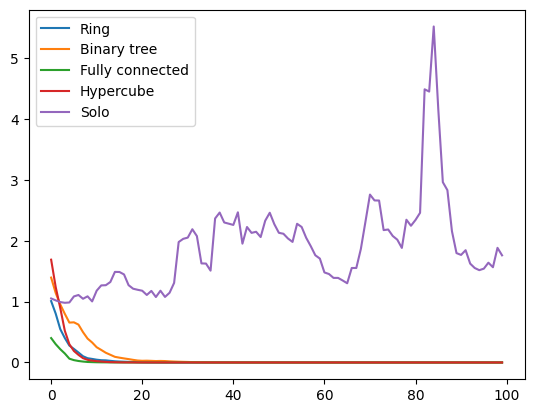

In [29]:
d = 4
n = 32
T = 100

topologies = [
        "Ring",
        "Binary tree",
        "Fully connected",
        "Hypercube",
        "Solo",
        "Time-varying exponential"
    ]

DSGD_toypbm(0.4, d, n, T, topologies, True)


In [16]:
def list_learning_rates():
    '''
    Creating the list of learning_rates for the two next algorithms
    '''
    li = []
    for k in range(-2, 0):
        for j in range(1, 10):
            li.append(j*10**k)
    for k in range(9):
        li.append(1. + k/10)
    return li

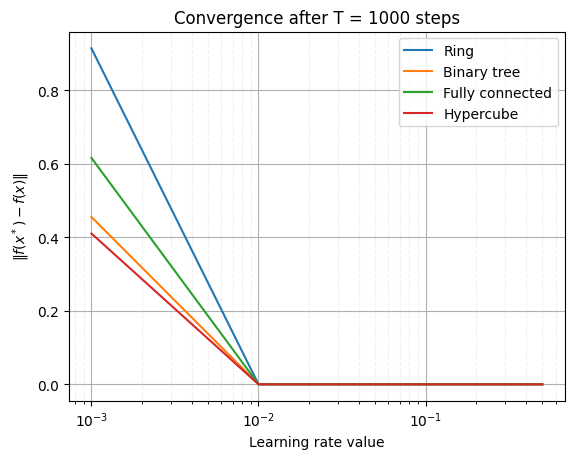

In [27]:
def learning_rate_dependency(d, n, T, topologies):
    """
    Plotting the value of the loss function after T steps for a given set of topologies, depending on the value of the learning rate

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """
    learning_rates_10 = [10**k for k in range(-3, 0)]
    learning_rates_5 = [5*10**k for k in range(-2, 0)]
    learning_rates = np.sort(learning_rates_10 + learning_rates_5)
    matrix = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for lr, k in zip(learning_rates, range(len(learning_rates))):
        matrix[k,:] = np.array(DSGD_toypbm(lr, d, n, T, topologies, False))
    for topology, j in zip(topologies, range(len(topologies))):
        ax.plot(learning_rates, matrix[:,j], label = topology)
        ax.set_xscale('log')
        ax.legend()
    ax.set_ylabel(f'$\| f(x^*) - f(x) \| $')
    ax.set_xlabel('Learning rate value')
    ax.set_title('Convergence after T = {} steps'.format(T))
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()

learning_rate_dependency(d, n, 1000, topologies[:-1])

/var/folders/gq/lmr1rzls51b2k01h5jq8j9cm0000gn/T/ipykernel_17659/3944544904.py:25: RuntimeWarning: overflow encountered in multiply
  X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
/var/folders/gq/lmr1rzls51b2k01h5jq8j9cm0000gn/T/ipykernel_17659/3944544904.py:25: RuntimeWarning: overflow encountered in subtract
  X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])


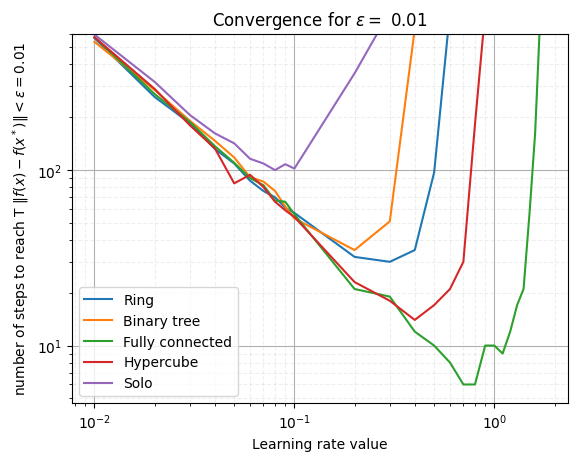

In [12]:
def DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon):
    """
    D-SGD algorithm for the toy-problem defined in section 3 (minimization of 1/2*||x||^2). This function returns
    the number of steps needed for the mean of the model in norm to be < epsilon

    Inputs :
    ------------
    lr: learning rate
    d: dimension
    n: number of agents
    topology: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    """
    
    W = Matrix.w(scheme_for_string(topology, num_workers=n)).numpy()
    x0 = rd.normal(0,1, size = (d))
    X = np.block([[x0]]*n)
    norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    T = 0
    while (np.abs(norm) > epsilon and T < T_max):
        if topology == "Time-varying exponential":
            W = Matrix.w(scheme_for_string(topology, num_workers=n), T).numpy()
        T += 1
        for i in range(n):
            v = rd.normal(0,1, size = (d,1))
            X[i,:] = X[i,:] - lr * v.dot(v.T).dot(X[i,:])
        X = W.dot(X)
        norm = np.mean(np.linalg.norm(X, axis = 1, ord = 2))
    return T, norm





def learning_rate_dependency_number_of_steps(d, n, topologies, T_max, epsilon):
    '''
    Plotting the number of steps needed depending on the value of the learning rate and the topology to reach an error of the loss function < epsilon.
    
    Inputs :
    ----------
    d: dimension
    n: number of agents
    topologies: the gossip matrix
    T_max: max number of time steps
    epsilon: the convergence value
    '''
    learning_rates = list_learning_rates()
    matrix_T = np.zeros((len(learning_rates), len(topologies)))
    fig, ax = plt.subplots()
    for topology, j in zip(topologies, range(len(topologies))):
        for lr, k in zip(learning_rates, range(len(learning_rates))):
            matrix_T[k,j] = DSGD_toypbm_epsilon(lr, d, n, topology, T_max, epsilon)[0]  
        ax.plot(learning_rates, matrix_T[:,j], label = topology)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    ax.set_ylabel(f'number of steps to reach T $\| f(x) - f(x^*)\| < \epsilon = ${epsilon}')
    ax.set_xlabel('Learning rate value')
    ax.set_ylim(top = 600)
    ax.set_title(f'Convergence for $\epsilon =$ {epsilon}')
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2, linestyle='--')
    plt.show()
learning_rate_dependency_number_of_steps(d, n, topologies, 800, 0.01)

In [191]:
def nW(gamma, W):
    """
    Computes the effective number of neighbours of the gossip matrix W for the decay parameter gamma
    """
    lambdas = np.linalg.eigvals(W)
    denominator = np.mean(lambdas**2 / (1 - gamma*lambdas**2))
    return 1/(1-gamma) * 1/denominator

In [ ]:
# The effective number of neighbours for the alone topology (W = I) should be 1 independently of gamma
nW(.5, np.eye(10))

1.0

In [ ]:
def rate_toypbm(lr, zeta, W):
    """
    Computes the convergence rate of D-SGD in the toy-problem case

    Inputs:
    ----------------
    lr: learning rate of D-SGD
    zeta: noise level (= d + 2 in the case of the toy-problem in dimension d)
    W: gossip matrix used for D-SGD

    Outputs:
    ----------------
    r: convergence rate of D-SGD
    """
    f_tosolve = lambda r : r - (1 - (1 - lr)**2 - (zeta - 1) * lr**2 / nW((1-lr)**2 / (1-r), W))
    r = optim.fsolve(f_tosolve)
    return r

In [ ]:
rate_toypbm(0.5, 6, np.eye(10))